In [1]:
import torch
import torchvision
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import math
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
root = '../Lab05/datasets/CelebAGaze/'

data_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1)
])

trainset2 = torchvision.datasets.ImageFolder(root, transform=data_transform2)

In [3]:
len(trainset2)

20000

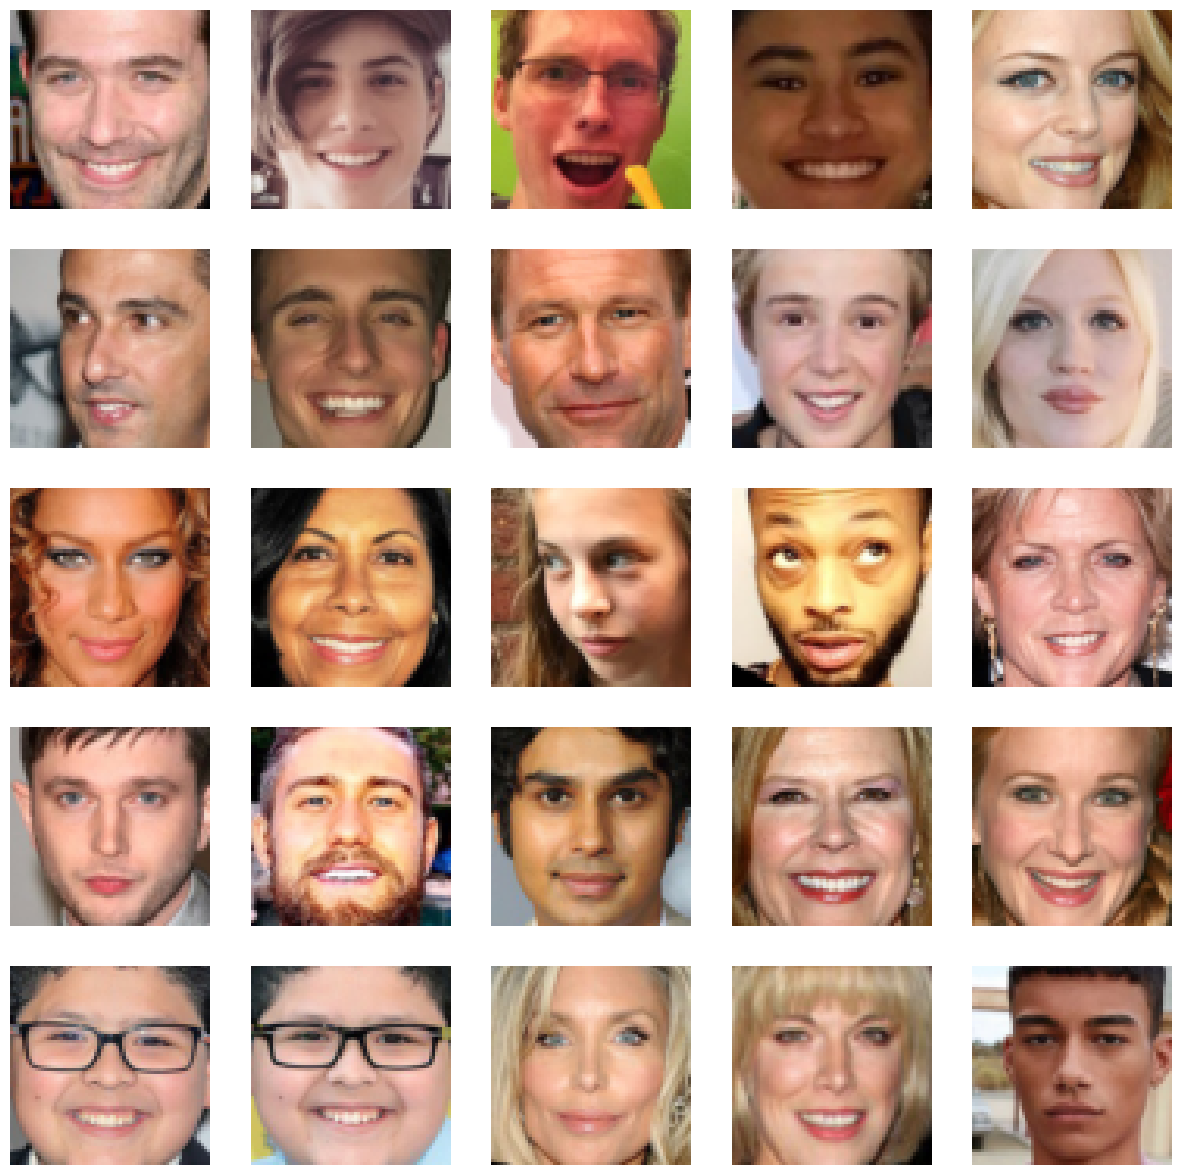

In [4]:
fig, axs = plt.subplots(5,5, figsize=(15,15))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(trainset2)-1)
        img, lab = trainset2[ix]
        ax.imshow(((img+1)/2).permute(1,2,0))
        ax.axis('off')
        #ax.set_title(classes[lab])
plt.show()

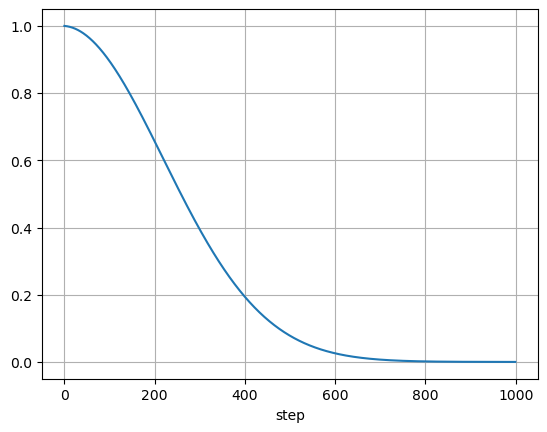

In [5]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0) # type: ignore
	return betas, alphas, alphas_hat

_, _, alphas_hat = noise_scheduler()

plt.plot(alphas_hat)
plt.xlabel('step')
plt.ylabel('', rotation=0)
plt.grid()
plt.show()

In [6]:
class Dataset(torch.utils.data.Dataset):
	def __init__(self, data, T=1000):
		self.data = data
		self.T = T
		self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, ix):
		im = self.data[ix][0] # imagen original
		y = torch.tensor([self.data[ix][1]]) # etiqueta
		t = torch.randint(0, self.T, (1,)) # se obtiene un numero aleatorio
		noise = torch.randn_like(im) # ruido
		x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
		return x.float(), noise.float(), t, y

In [7]:
ds = Dataset(trainset2)

In [10]:
img,noise,t,y = ds[1]
img.shape,noise.shape,t.shape,y.shape

(torch.Size([3, 64, 64]),
 torch.Size([3, 64, 64]),
 torch.Size([1]),
 torch.Size([1]))

In [11]:
img.max(),img.min(),noise.max(),noise.min()

(tensor(2.9667), tensor(-2.7959), tensor(3.9297), tensor(-3.5526))

In [12]:
t,y

(tensor([233]), tensor([0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


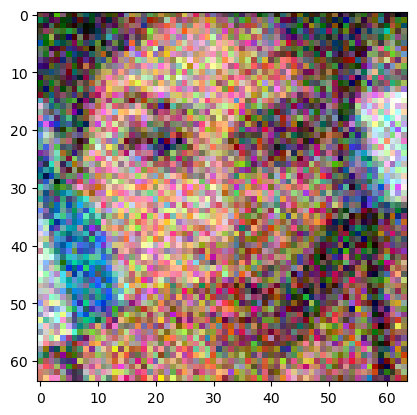

In [13]:
plt.imshow(((img-noise+1)/2).permute(1,2,0))

In [20]:

dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True, pin_memory=True)

In [21]:

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


class EncoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            conv3x3_bn(ci, co),
            conv3x3_bn(co, co),
        )
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x, t):
        x = self.conv(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class DecoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x1, x2, t):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class UNet2(torch.nn.Module):
    def __init__(self, out_ch=3, in_ch=1, embed_dim=32):
        super().__init__()
        # lista de capas en encoder-decoder con número de filtros
        c = [64, 128, 256, 512]
        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),
            conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = EncoderConv(c[0], c[1], embed_dim)
        self.conv3 = EncoderConv(c[1], c[2], embed_dim)
        self.conv4 = EncoderConv(c[2], c[3], embed_dim)
        # capas del decoder
        self.deconv1 = DecoderConv(c[3], c[2], embed_dim)
        self.deconv2 = DecoderConv(c[2], c[1], embed_dim)
        self.deconv3 = DecoderConv(c[1], c[0], embed_dim)
        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], out_ch, 3, padding=1)

    def forward(self, x, t):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1, t)
        x3 = self.conv3(x2, t)
        x = self.conv4(x3, t)
        # decoder
        x = self.deconv1(x, x3, t)
        x = self.deconv2(x, x2, t)
        x = self.deconv3(x, x1, t)
        x = self.out(x)
        return x

In [22]:

class DiffusionModel2(torch.nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
        self.label_embed = torch.nn.Linear(3, embed_dim)
        self.unet = UNet2(in_ch=3, out_ch=3, embed_dim=embed_dim)

    def forward(self, x, t, y=None):
        B, C, H, W = x.shape
        t = self.time_embed(t)
        if y is not None:
            y = torch.nn.functional.one_hot(y, 3).float()
            y = self.label_embed(y)
            t = t + y
        return self.unet(x, t)

In [23]:
im, noise, t, y = next(iter(dl))
im.shape, noise.shape, t.shape, y.shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 3, 64, 64]),
 torch.Size([32, 1]),
 torch.Size([32, 1]))

In [24]:

sd = DiffusionModel2().cuda()

In [25]:
y.cuda().squeeze(-1).shape

torch.Size([32])

In [26]:
a = sd(im.cuda(),t.cuda().squeeze(-1),y.cuda().squeeze(-1))
a.shape, a.max(), a.min()

(torch.Size([32, 3, 64, 64]),
 tensor(2.0532, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-2.2843, device='cuda:0', grad_fn=<MinBackward1>))

In [27]:
EPOCHS = 30

model = DiffusionModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
    losses = []
    pb = tqdm.tqdm(dl)
    for im, noise, t, y in pb:
        im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda().squeeze(-1)
        if np.random.rand() < 0.1:
            y = None
        output = model(im, t, y)
        loss = torch.nn.functional.mse_loss(output, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')
    torch.save(model, f'models/SD_v1_{epoch}.pth')

Epoch 30/30 loss 0.01909: 100%|██████████| 625/625 [01:37<00:00,  6.42it/s]


In [28]:
model = torch.load('models/SD_v1_30.pth')
x = torch.randn(1, 3, 64, 64).cuda()

model.eval()
output = model(x, torch.tensor([1]).cuda())
output.shape
print(output.max(), output.min())

tensor(9.2889, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-9.1432, device='cuda:0', grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(tensor(10.1679, device='cuda:0'), tensor(-13.8898, device='cuda:0'))


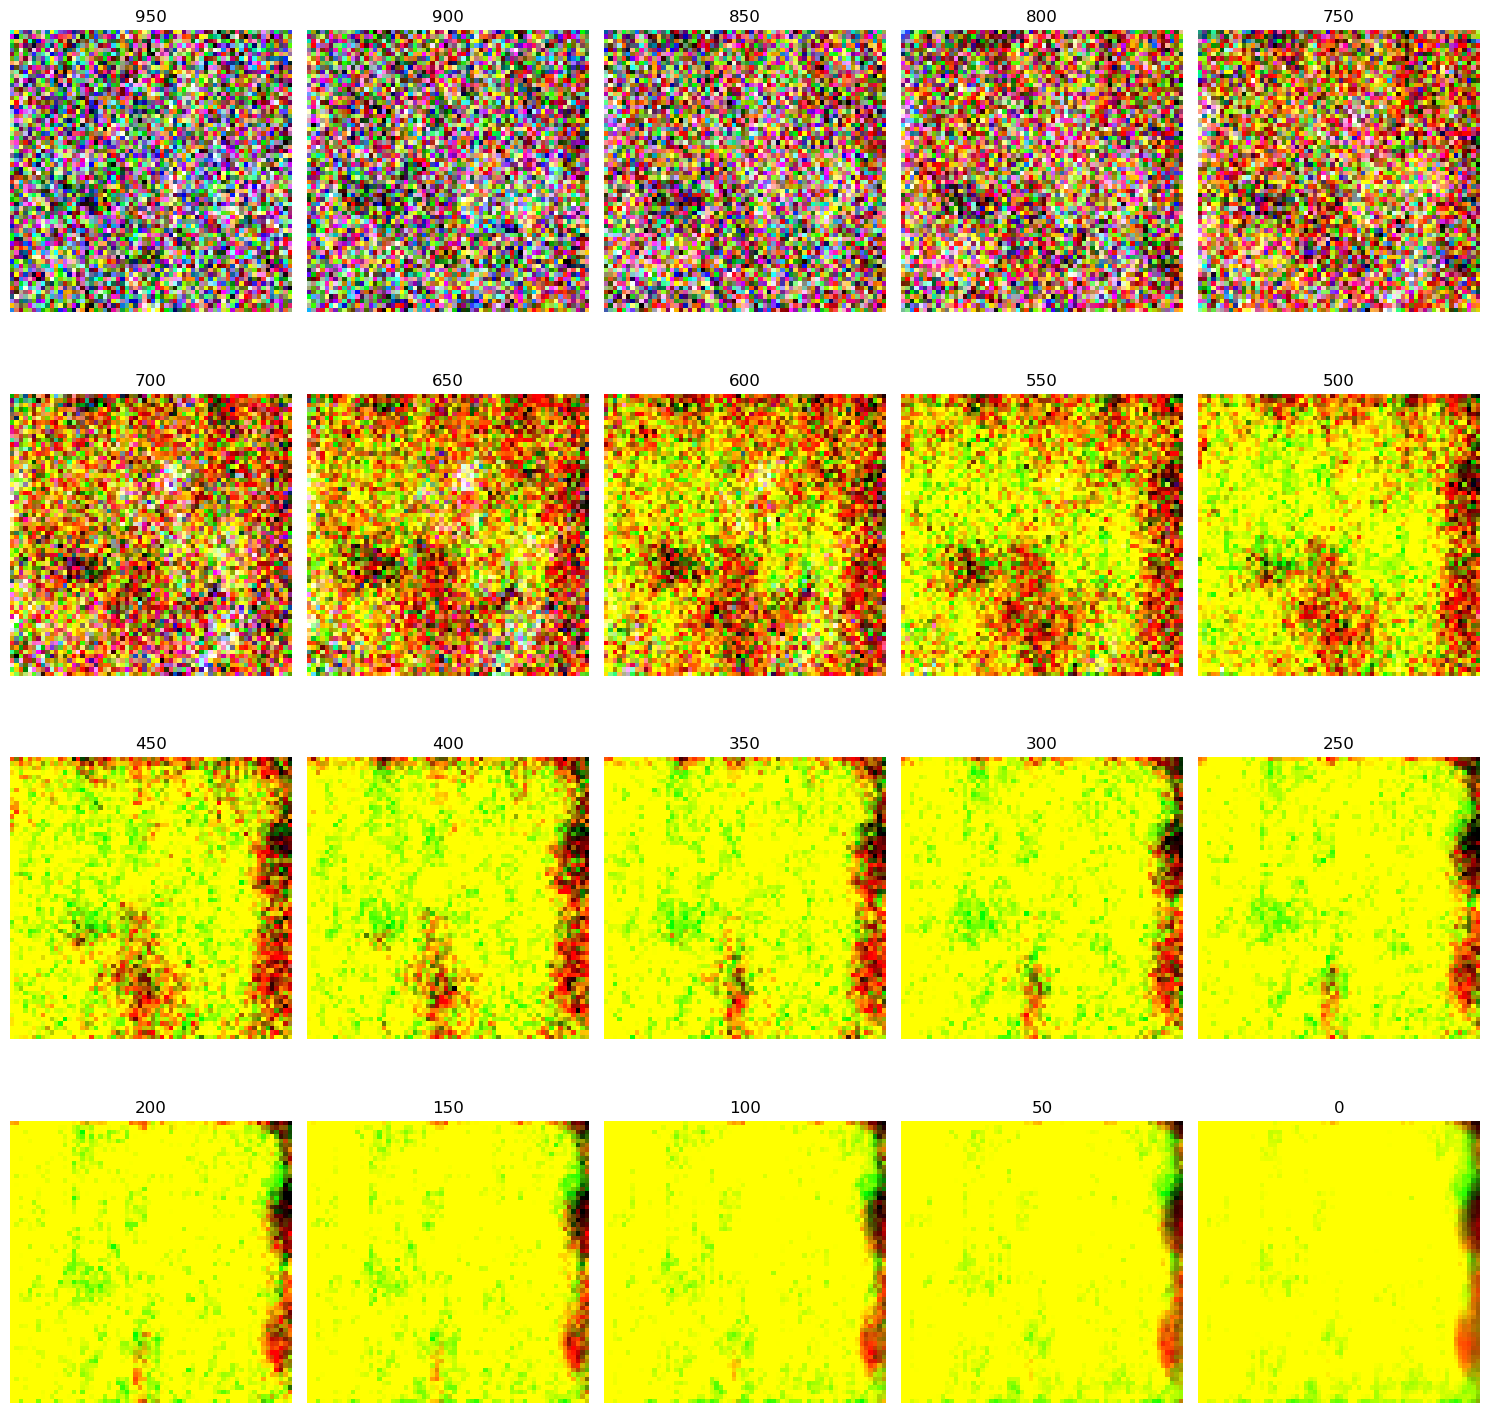

In [29]:
def sample():
	model.eval()
	x = torch.randn(1, 3, 64, 64).cuda()
	y = 1
	cfg = 0.5
	r, c = 4, 5
	fig = plt.figure(figsize=(15,15))
	i = 0
	for t in reversed(range(ds.T)):
		with torch.no_grad():
			output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
			#output_uncond = model(x, torch.tensor([t]).cuda(), None)
			#output  = torch.lerp(output_uncond, output, cfg)
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		# algoritmo para restar el ruido de manera progresiva propuesto en el paper
		x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
		if t % 50 == 0:
			i += 1
			ax = plt.subplot(r, c, i)
			#x[0] = torch.nn.Tanh()(x[0])
			ax.imshow(((x[0].cpu()+1)/2).permute(1,2,0))
			ax.axis("off")
			ax.set_title(t)
	print((x[0].max(),x[0].min()))
	plt.tight_layout()
	plt.show()

sample()

In [30]:

def generar(label=0):
    model.eval()
    r, c = 5, 5
    fig = plt.figure(figsize=(15,15))
    for i in range(r*c):
        x = torch.randn(1, 3, 64, 64).cuda()
        y = label
        for t in reversed(range(ds.T)):
            with torch.no_grad():
                output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
        ax = plt.subplot(r, c, i + 1)
        ax.imshow(((x[0].cpu()+1)/2).permute(1,2,0))
        #imgs = torch.nn.Sigmoid()(x[0])
        #ax.imshow(imgs.permute(1,2,0).cpu())
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

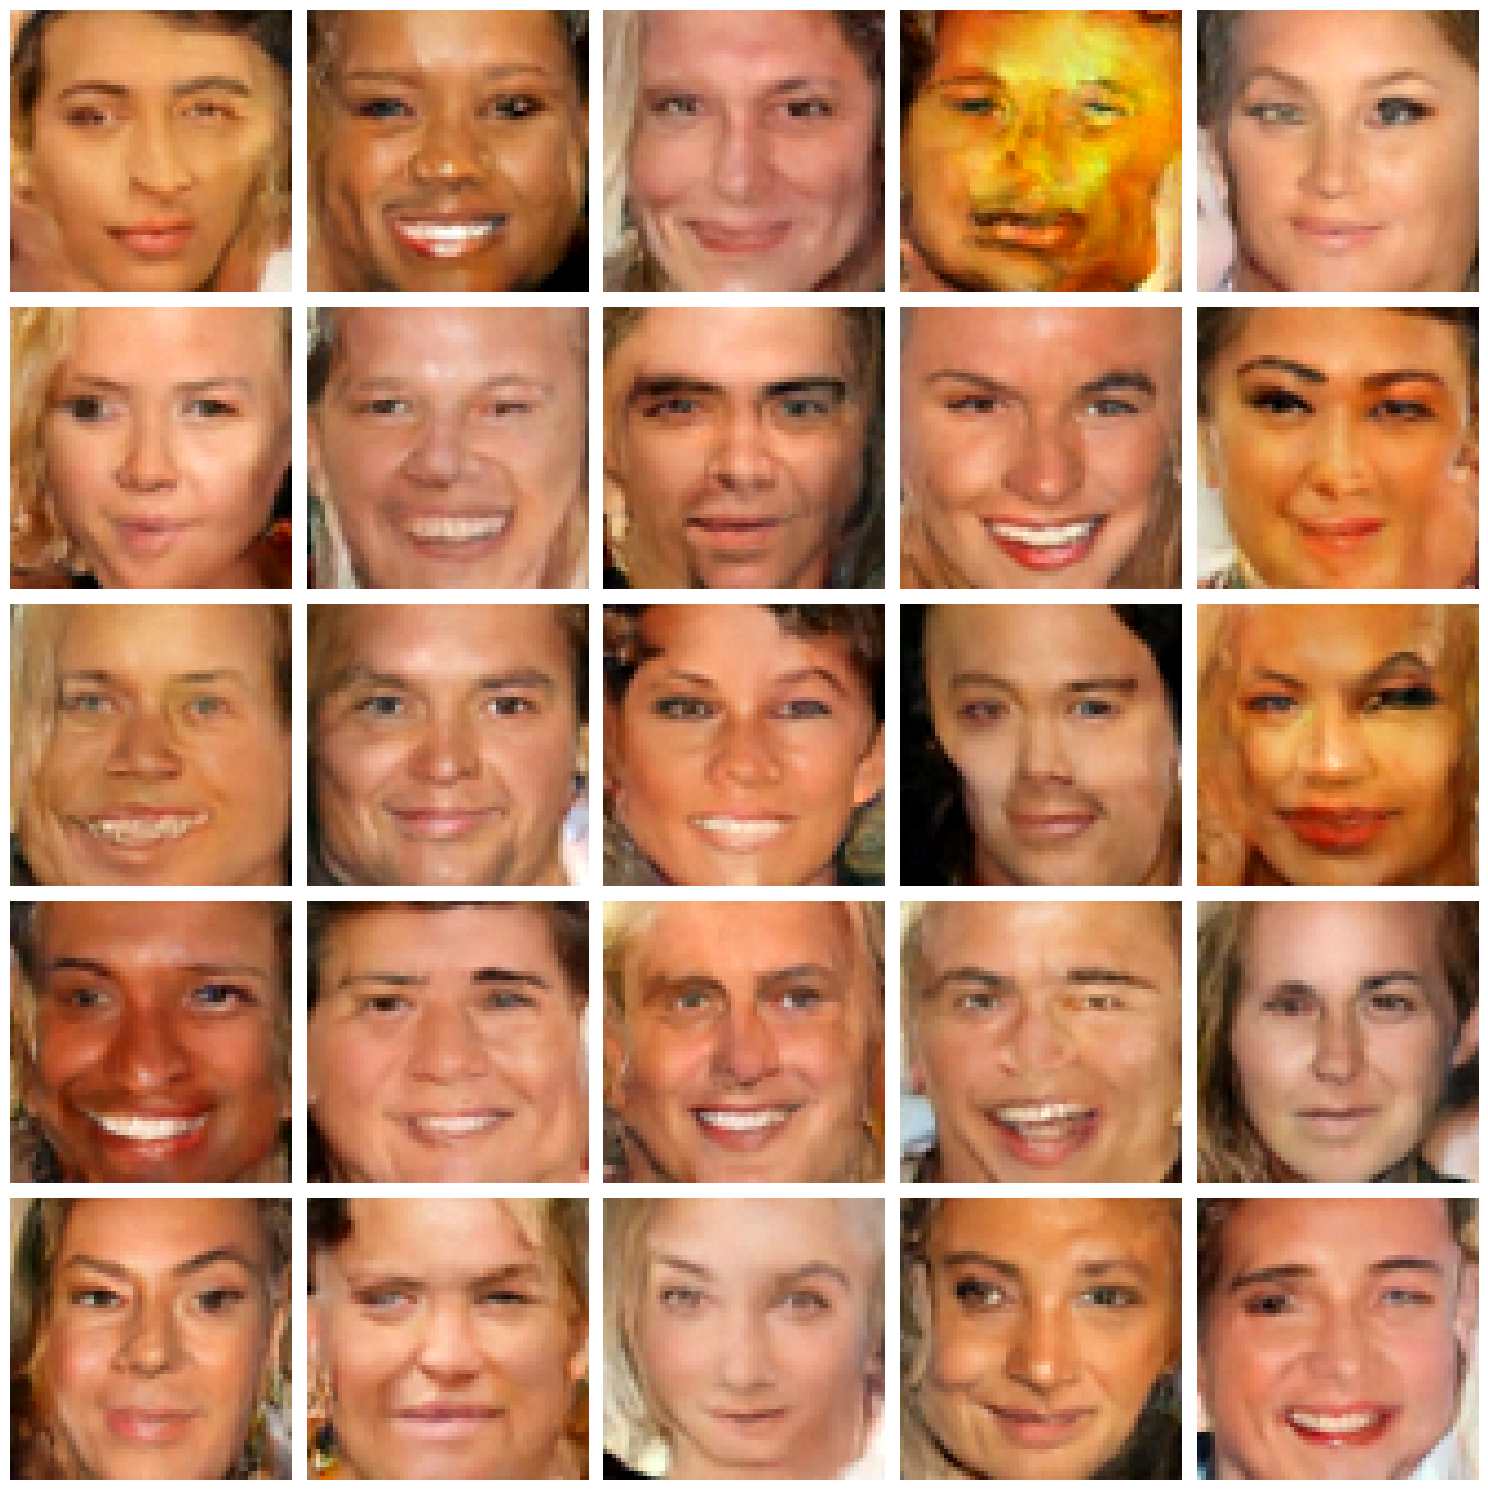

In [31]:
generar(0)# rostro